In [1]:
import matplotlib
import uproot, uproot3
import numpy
import awkward
import numba
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
import pandas as pd
from tqdm import trange
import ROOT
import os,sys
from array import array
import pickle

from Lumi import *
from Ratio_Plot import *
from TDR_Style import *

/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/uproot3/__init__.py:127: FutureWarning: Consider switching from 'uproot3' to 'uproot', since the new interface became the default in 2020.

    pip install -U uproot

In Python:

    >>> import uproot
    >>> with uproot.open(...) as file:
    ...

  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/awkward0/__init__.py:12: FutureWarning: Consider switching from 'awkward0' to 'awkward', since the new interface became the default in 2020.

    pip install -U awkward

In Python:

    >>> import awkward as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  warnings.warn(


Welcome to JupyROOT 6.24/06


In [2]:
def AddHist_data(file, hist,isbarrel,isData=True, xsec=1, lumi=1):
    
    
    # --read branches special case for MuonEG 2016H
    if 'MuonEG_Run2016H' in file:
        init_branches = [
                    'channel_mark'
                    ,'HLT_Ele27_WPTight_Gsf'
                    ,'HLT_IsoTkMu24'
                    ,'HLT_IsoMu24'
                    ,'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL'
                    ,'HLT_Mu17_TrkIsoVVL_TkMu8_TrkIsoVVL'
                    ,'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ'
                    ,'HLT_Mu17_TrkIsoVVL_TkMu8_TrkIsoVVL_DZ'
                    ,'HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL'
                    ,'HLT_Mu23_TrkIsoVVL_Ele8_CaloIdL_TrackIdL_IsoVL'
                    ,'HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL_DZ'
                    ,'HLT_Mu23_TrkIsoVVL_Ele8_CaloIdL_TrackIdL_IsoVL_DZ'
                    ,'HLT_Ele23_Ele12_CaloIdL_TrackIdL_IsoVL_DZ'
                    ,'photon_sieie'
                    ,'photon_vidNestedWPBitmap'
                    ,'photon_eta'
                    ,'photon_pt'
                    ,'photon_pfRelIso03_chg'
                    ,'MET'
                    ,"z_lepton1_pt"
                    ,"z_lepton2_pt"
                    ,"dilepton_mass"
                    ,"nJets"
        ]
        
    # --read branches 
    else:
        init_branches =[
                    'channel_mark'
                    ,'HLT_Ele27_WPTight_Gsf'
                    ,'HLT_IsoTkMu24'
                    ,'HLT_IsoMu24'
                    ,'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL'
                    ,'HLT_Mu17_TrkIsoVVL_TkMu8_TrkIsoVVL'
                    ,'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ'
                    ,'HLT_Mu17_TrkIsoVVL_TkMu8_TrkIsoVVL_DZ'
                    ,'HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL'
                    ,'HLT_Mu23_TrkIsoVVL_Ele8_CaloIdL_TrackIdL_IsoVL'
                    ,'HLT_Ele23_Ele12_CaloIdL_TrackIdL_IsoVL_DZ'
                    ,'photon_sieie'
                    ,'photon_vidNestedWPBitmap'
                    ,'photon_eta'
                    ,'photon_pt'
                    ,'photon_pfRelIso03_chg'
                    ,'MET'
                    ,"z_lepton1_pt"
                    ,"z_lepton2_pt"
                    ,"dilepton_mass"
                    ,"nJets"
        ]  
    
    # --Complete branches (data) 
    if isData:
        print('is Data')
 
                
    # --Complete branches (MC)
    else:
        print('is MC')
        add_branches = ['Generator_weight','puWeight','PrefireWeight']
        met_branches = uproot.open(file+':Events').keys(filter_name='MET_T1Smear*')
        gen_lepton_branches = uproot.open(file+':Events').keys(filter_name='*_lepton*genPartFlav')
        gen_photon_branches= uproot.open(file+':Events').keys(filter_name='*_photon*genPartFlav')
        true_events = uproot.open(file)['nEventsGenWeighted'].values()[0]
        init_branches.extend(add_branches)
        init_branches.extend(gen_lepton_branches)
        init_branches.extend(gen_photon_branches)
        init_branches.extend(met_branches)

                
    # --Prepare main branches
    branches = uproot.open(file+':Events').arrays(init_branches, library='pd')

                
                
    # --Triggers
    
    # Single Electron HLT
    HLT_SingleElectron = branches.loc[:,'HLT_Ele27_WPTight_Gsf'] == True

    # DoubleEG HLT
    HLT_DoubleEG = branches.loc[:,'HLT_Ele23_Ele12_CaloIdL_TrackIdL_IsoVL_DZ'] == True

    # Single MuonHLT
    HLT_SingleMuon1 = branches.loc[:,'HLT_IsoTkMu24'] == True
    HLT_SingleMuon2 = branches.loc[:,'HLT_IsoMu24'] == True
    comb_HLT_SingleMuon  = (HLT_SingleMuon1 | HLT_SingleMuon2)

    # Double Muon HLT
    HLT_DoubleMuon1 = branches.loc[:,'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL'] == True
    HLT_DoubleMuon2 = branches.loc[:,'HLT_Mu17_TrkIsoVVL_TkMu8_TrkIsoVVL'] == True
    HLT_DoubleMuon3 = branches.loc[:,'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ'] == True
    HLT_DoubleMuon4 = branches.loc[:,'HLT_Mu17_TrkIsoVVL_TkMu8_TrkIsoVVL_DZ'] == True
    if 'DoubleMuon_Run2016H'in file:
        comb_HLT_DoubleMuon = (HLT_DoubleMuon3 | HLT_DoubleMuon4)
    elif 'DoubleMuon_Run2016' in file:
        comb_HLT_DoubleMuon = (HLT_DoubleMuon1 | HLT_DoubleMuon2)
    else:
        comb_HLT_DoubleMuon = (HLT_DoubleMuon1 | HLT_DoubleMuon2) | (HLT_DoubleMuon3 | HLT_DoubleMuon4)

    # MuonEG HLT
    HLT_MuonEG1 = branches.loc[:,'HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL'] == True
    HLT_MuonEG2 = branches.loc[:,'HLT_Mu23_TrkIsoVVL_Ele8_CaloIdL_TrackIdL_IsoVL'] == True


    if 'MuonEG_Run2016H' in file:
        HLT_MuonEG3 = branches.loc[:,'HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL_DZ'] == True
        HLT_MuonEG4 = branches.loc[:,'HLT_Mu23_TrkIsoVVL_Ele8_CaloIdL_TrackIdL_IsoVL_DZ'] == True
        comb_HLT_MuonEG = (HLT_MuonEG1 | HLT_MuonEG2) | (HLT_MuonEG3 | HLT_MuonEG4)
    else:
        comb_HLT_MuonEG = (HLT_MuonEG1 | HLT_MuonEG2)


    
    # Apply trigger
    if 'SingleMuon' in file:
        print('SingleMuon trigger')
        arrays = branches.loc[comb_HLT_SingleMuon , :].copy()
    elif 'DoubleMuon' in file:
        print('DoubleMuon trigger')
        arrays = branches.loc[~comb_HLT_SingleMuon & comb_HLT_DoubleMuon, :].copy()
    elif 'SingleElectron' in file:
        print('SingleElectron trigger')
        arrays = branches.loc[~comb_HLT_SingleMuon & ~comb_HLT_DoubleMuon &   HLT_SingleElectron ,:].copy()
    elif 'MuonEG' in file:
        print('MuonEG Trigger')
        arrays = branches.loc[~comb_HLT_SingleMuon & ~comb_HLT_DoubleMuon &  ~HLT_SingleElectron & comb_HLT_MuonEG,:].copy()
    elif 'DoubleEG' in file:
        print('DoubleEG trigger')
        arrays = branches.loc[~comb_HLT_SingleMuon & ~comb_HLT_DoubleMuon &  ~HLT_SingleElectron & ~comb_HLT_MuonEG & HLT_DoubleEG,:].copy()
        
    else:
        print('isMC')
        arrays = branches.loc[comb_HLT_SingleMuon | comb_HLT_DoubleMuon | comb_HLT_MuonEG | HLT_SingleElectron |  HLT_DoubleEG ,:].copy()

    print('after trigger',len(arrays))    
        
    
    # --cuts
    
    # MET 
    if isData:
        MET_cut = (arrays.loc[:,'MET'] > 30)
    else:
        MET_cut = (arrays.loc[:,f'MET_T1Smear_pt'] > 30)
    arrays = arrays.loc[MET_cut,:]
    print('after MET',len(arrays))
    
    # lepton pt
    lepton_pt_mask = (arrays.loc[:,"z_lepton1_pt"] > 25) & (arrays.loc[:,"z_lepton2_pt"] > 20)
    arrays = arrays.loc[lepton_pt_mask,:]
    print('after pt',len(arrays))
    
    # Zmass window
    Zmass_mask     = abs(arrays.loc[:,"dilepton_mass"]-91.188) <= 15
    arrays = arrays.loc[Zmass_mask,:]
    print('after Zmass',len(arrays))
    
    # bjet veto
    bjet_veto_mask = arrays.loc[:,"nJets"] == 0
    arrays = arrays.loc[lepton_pt_mask & Zmass_mask & bjet_veto_mask,:]
    arrays = arrays.loc[bjet_veto_mask,:]
    print('after bjet_veto',len(arrays))

    
    # Photon Eta
    if isbarrel == 1:
        eta_cut = abs(arrays.loc[:,'photon_eta']) < 1.4442
    elif isbarrel == 0:
        eta_cut = abs((arrays.loc[:,'photon_eta']) > 1.566) & abs((arrays.loc[:,'photon_eta']) < 2.5)
    
    mask_mediumID = (1<<1) | (1<<3) | (1<<5) | (1<<7) | (1<<9) | (1<<11) | (1<<13)
    
    # Original Photon MediumID 
    arrays['mediumID'] = arrays['photon_vidNestedWPBitmap'] & mask_mediumID
    arrays = arrays.loc[arrays.loc[:,'mediumID'] == mask_mediumID, :]
    print('after Photon ID',len(arrays))
        
    # Photon PT
    pt_cut = (arrays.loc[:,'photon_pt'] >= 20)
    arrays = arrays.loc[pt_cut & eta_cut ,:]
    print('after photon pt eta',len(arrays))
    
    # -- Fill hist
    print("events: ",len(arrays))
    # data
    if isData:
        for i in trange(0, len(arrays['photon_pt']), desc=f'fill photonPT for {file}'):
            hist.Fill(float(arrays['photon_pt'].values[i]))
    # MC
    else:
        arrays['Generator_weight_sgn'] = arrays['Generator_weight'].apply(lambda x: 1 if x >= 0 else -1)
        arrays['true_weight'] = lumi * xsec * 1000 *  arrays['PrefireWeight'] * arrays['puWeight']*  arrays['Generator_weight_sgn'] / true_events   

        for i in trange(len(arrays['photon_pt']), desc=f'fill photonPT for {file}'):
            hist.Fill(float(arrays['photon_pt'].values[i]),float(arrays['true_weight'].values[i]))
    
def AddHist_dataFake(file, hist,isbarrel,isData=True,xsec=1,lumi=1):
    
    # --read branches special case for MuonEG 2016H
    if 'MuonEG_Run2016H' in file:
        init_branches = [
                    'channel_mark'
                    ,'HLT_Ele27_WPTight_Gsf'
                    ,'HLT_IsoTkMu24'
                    ,'HLT_IsoMu24'
                    ,'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL'
                    ,'HLT_Mu17_TrkIsoVVL_TkMu8_TrkIsoVVL'
                    ,'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ'
                    ,'HLT_Mu17_TrkIsoVVL_TkMu8_TrkIsoVVL_DZ'
                    ,'HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL'
                    ,'HLT_Mu23_TrkIsoVVL_Ele8_CaloIdL_TrackIdL_IsoVL'
                    ,'HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL_DZ'
                    ,'HLT_Mu23_TrkIsoVVL_Ele8_CaloIdL_TrackIdL_IsoVL_DZ'
                    ,'HLT_Ele23_Ele12_CaloIdL_TrackIdL_IsoVL_DZ'
                    ,'photon_sieie'
                    ,'photon_vidNestedWPBitmap'
                    ,'photon_eta'
                    ,'photon_pt'
                    ,'photon_pfRelIso03_chg'
                    ,'MET'
                    ,"z_lepton1_pt"
                    ,"z_lepton2_pt"
                    ,"dilepton_mass"
                    ,"nJets"
        ]
        
    # --read branches 
    else:
        init_branches = [
                    'channel_mark'
                    ,'HLT_Ele27_WPTight_Gsf'
                    ,'HLT_IsoTkMu24'
                    ,'HLT_IsoMu24'
                    ,'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL'
                    ,'HLT_Mu17_TrkIsoVVL_TkMu8_TrkIsoVVL'
                    ,'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ'
                    ,'HLT_Mu17_TrkIsoVVL_TkMu8_TrkIsoVVL_DZ'
                    ,'HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL'
                    ,'HLT_Mu23_TrkIsoVVL_Ele8_CaloIdL_TrackIdL_IsoVL'
                    ,'HLT_Ele23_Ele12_CaloIdL_TrackIdL_IsoVL_DZ'
                    ,'photon_sieie'
                    ,'photon_vidNestedWPBitmap'
                    ,'photon_eta'
                    ,'photon_pt'
                    ,'photon_pfRelIso03_chg'
                    ,'MET'
                    ,"z_lepton1_pt"
                    ,"z_lepton2_pt"
                    ,"dilepton_mass"
                    ,"nJets"
        ] 
    
    # --Complete branches (data) 
    if isData:
        print('is Data')

                
    # --Complete branches (MC)
    else:
        add_branches = ['Generator_weight','puWeight','PrefireWeight']
        met_branches = uproot.open(file+':Events').keys(filter_name='MET_T1Smear*')
        gen_lepton_branches = uproot.open(file+':Events').keys(filter_name='*_lepton*genPartFlav')
        gen_photon_branches= uproot.open(file+':Events').keys(filter_name='*_photon*genPartFlav')
        true_events = uproot.open(file)['nEventsGenWeighted'].values()[0]
        init_branches.extend(add_branches)
        init_branches.extend(gen_lepton_branches)
        init_branches.extend(gen_photon_branches)
        init_branches.extend(met_branches)

                
    # --Prepare main branches
    branches = uproot.open(file+':Events').arrays(init_branches, library='pd')
    
    # --Triggers
    
    # Single Electron HLT
    HLT_SingleElectron = branches.loc[:,'HLT_Ele27_WPTight_Gsf'] == True

    # DoubleEG HLT
    HLT_DoubleEG = branches.loc[:,'HLT_Ele23_Ele12_CaloIdL_TrackIdL_IsoVL_DZ'] == True

    # Single MuonHLT
    HLT_SingleMuon1 = branches.loc[:,'HLT_IsoTkMu24'] == True
    HLT_SingleMuon2 = branches.loc[:,'HLT_IsoMu24'] == True
    comb_HLT_SingleMuon  = (HLT_SingleMuon1 | HLT_SingleMuon2)

    # Double Muon HLT
    HLT_DoubleMuon1 = branches.loc[:,'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL'] == True
    HLT_DoubleMuon2 = branches.loc[:,'HLT_Mu17_TrkIsoVVL_TkMu8_TrkIsoVVL'] == True
    HLT_DoubleMuon3 = branches.loc[:,'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ'] == True
    HLT_DoubleMuon4 = branches.loc[:,'HLT_Mu17_TrkIsoVVL_TkMu8_TrkIsoVVL_DZ'] == True
    if 'DoubleMuon_Run2016H'in file:
        comb_HLT_DoubleMuon = (HLT_DoubleMuon3 | HLT_DoubleMuon4)
    elif 'DoubleMuon_Run2016' in file:
        comb_HLT_DoubleMuon = (HLT_DoubleMuon1 | HLT_DoubleMuon2)
    else:
        comb_HLT_DoubleMuon = (HLT_DoubleMuon1 | HLT_DoubleMuon2) | (HLT_DoubleMuon3 | HLT_DoubleMuon4)

    # MuonEG HLT
    HLT_MuonEG1 = branches.loc[:,'HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL'] == True
    HLT_MuonEG2 = branches.loc[:,'HLT_Mu23_TrkIsoVVL_Ele8_CaloIdL_TrackIdL_IsoVL'] == True


    if 'MuonEG_Run2016H' in file:
        HLT_MuonEG3 = branches.loc[:,'HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL_DZ'] == True
        HLT_MuonEG4 = branches.loc[:,'HLT_Mu23_TrkIsoVVL_Ele8_CaloIdL_TrackIdL_IsoVL_DZ'] == True
        comb_HLT_MuonEG = (HLT_MuonEG1 | HLT_MuonEG2) | (HLT_MuonEG3 | HLT_MuonEG4)
    else:
        comb_HLT_MuonEG = (HLT_MuonEG1 | HLT_MuonEG2)


    
    # Apply trigger
    if 'SingleMuon' in file:
        arrays = branches.loc[comb_HLT_SingleMuon , :].copy()
    elif 'DoubleMuon' in file:
        arrays = branches.loc[~comb_HLT_SingleMuon & comb_HLT_DoubleMuon, :].copy()
    elif 'SingleElectron' in file:
        arrays = branches.loc[~comb_HLT_SingleMuon & ~comb_HLT_DoubleMuon &   HLT_SingleElectron ,:].copy()
    elif 'MuonEG' in file:
        arrays = branches.loc[~comb_HLT_SingleMuon & ~comb_HLT_DoubleMuon &  ~HLT_SingleElectron & comb_HLT_MuonEG,:].copy()
    elif 'DoubleEG' in file:
        arrays = branches.loc[~comb_HLT_SingleMuon & ~comb_HLT_DoubleMuon &  ~HLT_SingleElectron & ~comb_HLT_MuonEG & HLT_DoubleEG,:].copy()
        
    else:
        arrays = branches.loc[comb_HLT_SingleMuon | comb_HLT_DoubleMuon | comb_HLT_MuonEG | HLT_SingleElectron |  HLT_DoubleEG ,:].copy()

    
    # --cuts
    # MET 
    if isData:
        MET_cut = (arrays.loc[:,'MET'] > 30)
    else:
        MET_cut = (arrays.loc[:,f'MET_T1Smear_pt'] > 30)
    arrays = arrays.loc[MET_cut,:]

    # lepton pt
    lepton_pt_mask = (arrays.loc[:,"z_lepton1_pt"] > 25) & (arrays.loc[:,"z_lepton2_pt"] > )
    arrays = arrays.loc[lepton_pt_mask,:]
    print('after pt',len(arrays))
    
    # Zmass window
    Zmass_mask     = abs(arrays.loc[:,"dilepton_mass"]-91.188) <= 15
    arrays = arrays.loc[Zmass_mask,:]
    print('after Zmass',len(arrays))
    
    # bjet veto
    bjet_veto_mask = arrays.loc[:,"nJets"] == 0
    arrays = arrays.loc[lepton_pt_mask & Zmass_mask & bjet_veto_mask,:]
    arrays = arrays.loc[bjet_veto_mask,:]
    print('after bjet_veto',len(arrays))
    
    
    # Photon Eta
    if isbarrel == 1:
        eta_cut = abs(arrays.loc[:,'photon_eta']) < 1.4442
    elif isbarrel == 0:
        eta_cut = abs((arrays.loc[:,'photon_eta']) > 1.566) & abs((arrays.loc[:,'photon_eta']) < 2.5)        
        
    # Photon IsoChg SB cut
    sb = [4,10]

    chg_cut = ((arrays.loc[:,"photon_pfRelIso03_chg"]*arrays.loc[:,"photon_pt"]) > sb[0]) & ((arrays.loc[:,"photon_pfRelIso03_chg"]*arrays.loc[:,"photon_pt"]) < sb[1])
    pt_cut  = (arrays.loc[:,'photon_pt'] >= 20)        
    
    arrays = arrays.loc[pt_cut & eta_cut & chg_cut,:]
    
    
    # -- Fill hist
    
    print("events: ",len(arrays))
    # data
    if isData:
        for i in trange(0, len(arrays['photon_pt']), desc=f'fill photonPT for {file}'):
            hist.Fill(float(arrays['photon_pt'].values[i]))
    # MC
    else:

        arrays['Generator_weight_sgn'] = arrays['Generator_weight'].apply(lambda x: 1 if x >= 0 else -1)
        arrays['true_weight'] = lumi * xsec * 1000 *  arrays['PrefireWeight'] * arrays['puWeight'] *  arrays['Generator_weight_sgn'] / true_events   

        for i in trange(len(arrays['photon_pt']), desc=f'fill photonPT for {file}'):
            hist.Fill(float(arrays['photon_pt'].values[i]),float(arrays['true_weight'].values[i]))

In [3]:
## 2016 CR

filelist_data = [
"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016B.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016C.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016D.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016E.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016F.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016G.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016H.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016B.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016C.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016D.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016E.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016F.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016G.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016H.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016B.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016C.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016D.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016E.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016F.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016G.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016H.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016B.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016C.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016D.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016E.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016F.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016G.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016H.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016B.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016C.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016D.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016E.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016F.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016G.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016H.root"
]

In [4]:
filelist_MC = {
    
   "TTG":
        {"name":"TTGJets",
        "path":"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/TTGJets_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8_2016.root",
        "xsec":4.078,
        },
   "TTZ":
        {"name":"TTZToLLNuNu",
        "path":"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/TTZToLLNuNu_M-10_TuneCP5_13TeV-amcatnlo-pythia8_2016.root",
        "xsec":0.2432,
        },
   "TTW":
        {"name":"TTWJetsToLNu",
        "path":"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/TTWJetsToLNu_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8_2016.root",
        "xsec":0.2149,
        },
   "tZq":
        {"name":"tZq_ll",
        "path":"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/tZq_ll_4f_ckm_NLO_TuneCP5_13TeV-amcatnlo-pythia8_2016.root",
        "xsec":0.07358,
        },
   "WWW":
        {"name":"WWW",
        "path":"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/WWW_4F_TuneCP5_13TeV-amcatnlo-pythia8_2016.root",
        "xsec":0.2086,
        },
   "ZGToLLG":
        {"name":"ZGToLLG",
        "path":"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/ZGToLLG_01J_5f_TuneCP5_13TeV-amcatnloFXFX-pythia8_2016.root",
        "xsec":55.48,
        },
    "ZZ":
        {"name":"ZZ",
        "path":"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/ZZ_TuneCP5_13TeV-pythia8_2016.root",
        "xsec":16.523, # NLO
        },
    "WZG":
        {"name":"WZG",
        "path":"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/wza_2016.root",
        "xsec":0.0384,
        },
   "WWZ":
        {"name":"WWZ",
        "path":"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/WWZ_4F_TuneCP5_13TeV-amcatnlo-pythia8_2016.root",
        "xsec":0.1707,
        },
   "ggZZ_2e2mu":
        {"name":"ggZZ2e2mu",
        "path":"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/GluGluToContinToZZTo2e2mu_TuneCP5_13TeV-mcfm701-pythia8_2016.root",
        "xsec":0.00319,
        },
#   "ggZZ_2e2nu":
#        {"name":"ggZZ2e2nu",
#        "path":"/eos/home-j/jiwoong/SWAN_projects/Draw/2017/GluGluToContinToZZTo2e2nu_TuneCP5_13TeV-mcfm701-pythia8_2017_0000.root",
#        "xsec":0.00319,
#        },
   "ggZZ_2e2tau":
        {"name":"ggZZ2e2tau",
        "path":"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/GluGluToContinToZZTo2e2tau_TuneCP5_13TeV-mcfm701-pythia8_2016.root",
        "xsec":0.00319,
        },
#   "ggZZ_2mu2nu":
#        {"name":"ggZZ2mu2nu",
#        "path":"/eos/home-j/jiwoong/SWAN_projects/Draw/2017/GluGluToContinToZZTo2mu2nu_TuneCP5_13TeV-mcfm701-pythia8_2017_0000.root",
#        "xsec":0.00319,
#        },
   "ggZZ_2mu2tau":
        {"name":"ggZZ2mu2tau",
        "path":"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/GluGluToContinToZZTo2mu2tau_TuneCP5_13TeV-mcfm701-pythia8_2016.root",
        "xsec":0.00319,
        },
   "ggZZ_4e":
        {"name":"ggZZ4e",
        "path":"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/GluGluToContinToZZTo4e_TuneCP5_13TeV-mcfm701-pythia8_2016.root",
        "xsec":0.00159,
        },
   "ggZZ_4mu":
        {"name":"ggZZ4mu",
        "path":"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/GluGluToContinToZZTo4mu_TuneCP5_13TeV-mcfm701-pythia8_2016.root",
        "xsec":0.00159,
        },
   "ggZZ_4tau":
        {"name":"ggZZ4tau",
        "path":"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/GluGluToContinToZZTo4tau_TuneCP5_13TeV-mcfm701-pythia8_2016.root",
        "xsec":0.00159,
        }    
}

In [5]:
from array import array



# Origin
xbins_EB = [20,30,50,80,120,180]
xbins_EE = [20,50,180]

# Tunning
#xbins_EB = [20,35,400]
#xbins_EE = [20,400]



isbarrel = 1 # barrel
#isbarrel = 0 # endcap


nbins=-1
if isbarrel == 1:
    xbins = xbins_EB
    nbins = len(xbins_EB) - 1
elif isbarrel ==0:
    xbins = xbins_EE
    nbins = len(xbins_EE) - 1
else:
    print("wrong!")
    
# Data template
hist_data = ROOT.TH1F("","",nbins,array('d',xbins))
hist_data.Sumw2()
# data
for file in filelist_data:
    AddHist_data(file, hist_data, isbarrel)   
# MC
for file in filelist_MC:
    AddHist_data(filelist_MC[file]['path'], hist_data,isbarrel,False,filelist_MC[file]['xsec'],35.86)                    

    
    
# --Fake template
hist_datafake = ROOT.TH1F("","",nbins,array('d',xbins))
hist_datafake.Sumw2()
# data
for file in filelist_data:
    AddHist_dataFake(file, hist_datafake,isbarrel,True)
# MC
for file in filelist_MC:
    AddHist_dataFake(filelist_MC[file]['path'], hist_datafake,isbarrel,False,filelist_MC[file]['xsec'],35.86)
    
    


is Data
DoubleEG trigger
after trigger 2150
after MET 666
after pt 100
after Zmass 30
after bjet_veto 28
after Photon ID 7
after photon pt eta 6
events:  6


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016B.root: 100%|██████████| 6/6 [00:00<00:00, 1026.21it/s]

is Data


DoubleEG trigger
after trigger 978
after MET 325
after pt 55
after Zmass 21
after bjet_veto 21
after Photon ID 8
after photon pt eta 5
events:  5


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016C.root: 100%|██████████| 5/5 [00:00<00:00, 27850.62it/s]

is Data


DoubleEG trigger
after trigger 1533
after MET 559
after pt 92
after Zmass 33
after bjet_veto 33
after Photon ID 6
after photon pt eta 5
events:  5


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016D.root: 100%|██████████| 5/5 [00:00<00:00, 33235.37it/s]

is Data


DoubleEG trigger
after trigger 1394
after MET 540
after pt 127
after Zmass 52
after bjet_veto 49
after Photon ID 14
after photon pt eta 9
events:  9


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016E.root: 100%|██████████| 9/9 [00:00<00:00, 60983.42it/s]

is Data


DoubleEG trigger
after trigger 1194
after MET 461
after pt 39
after Zmass 12
after bjet_veto 12
after Photon ID 2
after photon pt eta 2
events:  2


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016F.root: 100%|██████████| 2/2 [00:00<00:00, 20068.44it/s]

is Data


DoubleEG trigger
after trigger 3355
after MET 1376
after pt 369
after Zmass 150
after bjet_veto 141
after Photon ID 37
after photon pt eta 28
events:  28


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016G.root: 100%|██████████| 28/28 [00:00<00:00, 45572.57it/s]

is Data


DoubleEG trigger
after trigger 3626
after MET 1570
after pt 341
after Zmass 146
after bjet_veto 141
after Photon ID 32
after photon pt eta 24
events:  24


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016H.root: 100%|██████████| 24/24 [00:00<00:00, 57819.24it/s]

is Data


DoubleMuon trigger
after trigger 1617
after MET 560
after pt 91
after Zmass 20
after bjet_veto 20
after Photon ID 4
after photon pt eta 2
events:  2


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016B.root: 100%|██████████| 2/2 [00:00<00:00, 8612.53it/s]

is Data


DoubleMuon trigger
after trigger 708
after MET 256
after pt 73
after Zmass 8
after bjet_veto 8
after Photon ID 3
after photon pt eta 0
events:  0


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016C.root: 0it [00:00, ?it/s]

is Data


DoubleMuon trigger
after trigger 1145
after MET 385
after pt 99
after Zmass 14
after bjet_veto 12
after Photon ID 2
after photon pt eta 1
events:  1


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016D.root: 100%|██████████| 1/1 [00:00<00:00, 7463.17it/s]

is Data


DoubleMuon trigger
after trigger 1120
after MET 436
after pt 145
after Zmass 28
after bjet_veto 28
after Photon ID 10
after photon pt eta 6
events:  6


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016E.root: 100%|██████████| 6/6 [00:00<00:00, 24745.16it/s]

is Data


DoubleMuon trigger
after trigger 912
after MET 360
after pt 143
after Zmass 26
after bjet_veto 25
after Photon ID 4
after photon pt eta 4
events:  4


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016F.root: 100%|██████████| 4/4 [00:00<00:00, 36954.22it/s]

is Data


DoubleMuon trigger
after trigger 2478
after MET 1057
after pt 504
after Zmass 117
after bjet_veto 106
after Photon ID 25
after photon pt eta 21
events:  21


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016G.root: 100%|██████████| 21/21 [00:00<00:00, 61680.94it/s]

is Data


DoubleMuon trigger
after trigger 2712
after MET 1146
after pt 418
after Zmass 101
after bjet_veto 93
after Photon ID 22
after photon pt eta 14
events:  14


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016H.root: 100%|██████████| 14/14 [00:00<00:00, 89376.34it/s]

is Data


MuonEG Trigger
after trigger 181
after MET 122
after pt 58
after Zmass 8
after bjet_veto 6
after Photon ID 3
after photon pt eta 1
events:  1


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016B.root: 100%|██████████| 1/1 [00:00<00:00, 6797.90it/s]

is Data


MuonEG Trigger
after trigger 76
after MET 58
after pt 15
after Zmass 5
after bjet_veto 2
after Photon ID 0
after photon pt eta 0
events:  0


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016C.root: 0it [00:00, ?it/s]

is Data


MuonEG Trigger
after trigger 126
after MET 87
after pt 33
after Zmass 3
after bjet_veto 2
after Photon ID 2
after photon pt eta 1
events:  1


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016D.root: 100%|██████████| 1/1 [00:00<00:00, 3148.88it/s]

is Data


MuonEG Trigger
after trigger 133
after MET 90
after pt 38
after Zmass 5
after bjet_veto 3
after Photon ID 2
after photon pt eta 1
events:  1


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016E.root: 100%|██████████| 1/1 [00:00<00:00, 9098.27it/s]

is Data


MuonEG Trigger
after trigger 114
after MET 63
after pt 25
after Zmass 4
after bjet_veto 4
after Photon ID 0
after photon pt eta 0
events:  0


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016F.root: 0it [00:00, ?it/s]

is Data


MuonEG Trigger
after trigger 280
after MET 206
after pt 111
after Zmass 13
after bjet_veto 7
after Photon ID 3
after photon pt eta 2
events:  2


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016G.root: 100%|██████████| 2/2 [00:00<00:00, 13168.93it/s]

is Data


MuonEG Trigger
after trigger 276
after MET 196
after pt 71
after Zmass 12
after bjet_veto 8
after Photon ID 3
after photon pt eta 3
events:  3


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016H.root: 100%|██████████| 3/3 [00:00<00:00, 11008.67it/s]

is Data


SingleElectron trigger
after trigger 17501
after MET 6138
after pt 761
after Zmass 492
after bjet_veto 473
after Photon ID 113
after photon pt eta 84
events:  84


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016B.root: 100%|██████████| 84/84 [00:00<00:00, 165409.17it/s]

is Data


SingleElectron trigger
after trigger 7197
after MET 2776
after pt 291
after Zmass 213
after bjet_veto 194
after Photon ID 44
after photon pt eta 29
events:  29


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016C.root: 100%|██████████| 29/29 [00:00<00:00, 127499.81it/s]

is Data


SingleElectron trigger
after trigger 12090
after MET 4559
after pt 629
after Zmass 388
after bjet_veto 366
after Photon ID 82
after photon pt eta 61
events:  61


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016D.root: 100%|██████████| 61/61 [00:00<00:00, 149796.57it/s]

is Data


SingleElectron trigger
after trigger 10390
after MET 4194
after pt 692
after Zmass 458
after bjet_veto 440
after Photon ID 91
after photon pt eta 66
events:  66


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016E.root: 100%|██████████| 66/66 [00:00<00:00, 65660.36it/s]

is Data


SingleElectron trigger
after trigger 8234
after MET 3456
after pt 579
after Zmass 407
after bjet_veto 393
after Photon ID 97
after photon pt eta 74
events:  74


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016F.root: 100%|██████████| 74/74 [00:00<00:00, 170350.44it/s]

is Data


SingleElectron trigger
after trigger 23451
after MET 9886
after pt 2021
after Zmass 1383
after bjet_veto 1312
after Photon ID 293
after photon pt eta 219
events:  219


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016G.root: 100%|██████████| 219/219 [00:00<00:00, 208194.15it/s]

is Data


SingleElectron trigger
after trigger 26053
after MET 11373
after pt 2199
after Zmass 1522
after bjet_veto 1421
after Photon ID 289
after photon pt eta 206
events:  206


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016H.root: 100%|██████████| 206/206 [00:00<00:00, 88355.31it/s]

is Data


SingleMuon trigger
after trigger 26828
after MET 9448
after pt 1465
after Zmass 888
after bjet_veto 825
after Photon ID 214
after photon pt eta 162
events:  162


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016B.root: 100%|██████████| 162/162 [00:00<00:00, 214210.99it/s]

is Data


SingleMuon trigger
after trigger 12592
after MET 4912
after pt 1081
after Zmass 621
after bjet_veto 576
after Photon ID 173
after photon pt eta 142
events:  142


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016C.root: 100%|██████████| 142/142 [00:00<00:00, 185715.99it/s]

is Data


SingleMuon trigger
after trigger 20697
after MET 7969
after pt 1335
after Zmass 784
after bjet_veto 727
after Photon ID 167
after photon pt eta 123
events:  123


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016D.root: 100%|██████████| 123/123 [00:00<00:00, 118081.80it/s]

is Data


SingleMuon trigger
after trigger 18656
after MET 7760
after pt 1402
after Zmass 810
after bjet_veto 760
after Photon ID 188
after photon pt eta 145
events:  145


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016E.root: 100%|██████████| 145/145 [00:00<00:00, 204910.40it/s]

is Data


SingleMuon trigger
after trigger 14784
after MET 6263
after pt 1263
after Zmass 755
after bjet_veto 709
after Photon ID 185
after photon pt eta 130
events:  130


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016F.root: 100%|██████████| 130/130 [00:00<00:00, 192263.58it/s]

is Data


SingleMuon trigger
after trigger 40818
after MET 17351
after pt 4592
after Zmass 2709
after bjet_veto 2522
after Photon ID 566
after photon pt eta 423
events:  423


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016G.root: 100%|██████████| 423/423 [00:00<00:00, 213757.90it/s]

is Data


SingleMuon trigger
after trigger 47810
after MET 21097
after pt 5074
after Zmass 3043
after bjet_veto 2823
after Photon ID 632
after photon pt eta 462
events:  462


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016H.root: 100%|██████████| 462/462 [00:00<00:00, 214378.63it/s]

is MC


isMC
after trigger 32620
after MET 29233
after pt 17349
after Zmass 3224
after bjet_veto 1090
after Photon ID 835
after photon pt eta 689
events:  689


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/TTGJets_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8_2016.root: 100%|██████████| 689/689 [00:00<00:00, 48092.45it/s]

is MC


isMC
after trigger 170133
after MET 139256
after pt 127840
after Zmass 76130
after bjet_veto 24851
after Photon ID 5922
after photon pt eta 4388
events:  4388


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/TTZToLLNuNu_M-10_TuneCP5_13TeV-amcatnlo-pythia8_2016.root: 100%|██████████| 4388/4388 [00:00<00:00, 99300.25it/s]

is MC


isMC
after trigger 45760
after MET 41845
after pt 36463
after Zmass 6703
after bjet_veto 2256
after Photon ID 658
after photon pt eta 478
events:  478


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/TTWJetsToLNu_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8_2016.root: 100%|██████████| 478/478 [00:00<00:00, 127164.61it/s]

is MC


isMC
after trigger 129340
after MET 86420
after pt 77846
after Zmass 54819
after bjet_veto 24939
after Photon ID 5535
after photon pt eta 4055
events:  4055


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/tZq_ll_4f_ckm_NLO_TuneCP5_13TeV-amcatnlo-pythia8_2016.root: 100%|██████████| 4055/4055 [00:00<00:00, 99800.51it/s]

is MC


isMC
after trigger 148
after MET 134
after pt 29
after Zmass 2
after bjet_veto 2
after Photon ID 0
after photon pt eta 0
events:  0


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/WWW_4F_TuneCP5_13TeV-amcatnlo-pythia8_2016.root: 0it [00:00, ?it/s]

is MC


isMC
after trigger 3877650
after MET 1194133
after pt 973545
after Zmass 359179
after bjet_veto 352789
after Photon ID 273861
after photon pt eta 212609
events:  212609


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/ZGToLLG_01J_5f_TuneCP5_13TeV-amcatnloFXFX-pythia8_2016.root: 100%|██████████| 212609/212609 [00:02<00:00, 99449.85it/s] 


is MC
isMC
after trigger 5896
after MET 2329
after pt 1851
after Zmass 1408
after bjet_veto 1297
after Photon ID 324
after photon pt eta 235
events:  235


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/ZZ_TuneCP5_13TeV-pythia8_2016.root: 100%|██████████| 235/235 [00:00<00:00, 123253.90it/s]

is MC


isMC
after trigger 23791
after MET 18780
after pt 16029
after Zmass 5533
after bjet_veto 5469
after Photon ID 4319
after photon pt eta 3394
events:  3394


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/wza_2016.root: 100%|██████████| 3394/3394 [00:00<00:00, 130098.13it/s]

is MC


isMC
after trigger 572
after MET 457
after pt 322
after Zmass 176
after bjet_veto 172
after Photon ID 59
after photon pt eta 44
events:  44


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/WWZ_4F_TuneCP5_13TeV-amcatnlo-pythia8_2016.root: 100%|██████████| 44/44 [00:00<00:00, 55856.35it/s]

is MC


isMC
after trigger 287912
after MET 94017
after pt 85068
after Zmass 57414
after bjet_veto 56765
after Photon ID 40573
after photon pt eta 31002
events:  31002


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/GluGluToContinToZZTo2e2mu_TuneCP5_13TeV-mcfm701-pythia8_2016.root: 100%|██████████| 31002/31002 [00:00<00:00, 131030.26it/s]


is MC
isMC
after trigger 36880
after MET 22389
after pt 19531
after Zmass 14498
after bjet_veto 14236
after Photon ID 3547
after photon pt eta 2808
events:  2808


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/GluGluToContinToZZTo2e2tau_TuneCP5_13TeV-mcfm701-pythia8_2016.root: 100%|██████████| 2808/2808 [00:00<00:00, 96026.14it/s]

is MC


isMC
after trigger 46554
after MET 27426
after pt 24023
after Zmass 19959
after bjet_veto 19627
after Photon ID 4461
after photon pt eta 3535
events:  3535


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/GluGluToContinToZZTo2mu2tau_TuneCP5_13TeV-mcfm701-pythia8_2016.root: 100%|██████████| 3535/3535 [00:00<00:00, 130303.68it/s]

is MC


isMC
after trigger 448806
after MET 149564
after pt 136357
after Zmass 84327
after bjet_veto 83448
after Photon ID 59991
after photon pt eta 44683
events:  44683


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/GluGluToContinToZZTo4e_TuneCP5_13TeV-mcfm701-pythia8_2016.root: 100%|██████████| 44683/44683 [00:00<00:00, 99294.91it/s]


is MC
isMC
after trigger 723069
after MET 229703
after pt 206429
after Zmass 140389
after bjet_veto 138896
after Photon ID 98807
after photon pt eta 84241
events:  84241


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/GluGluToContinToZZTo4mu_TuneCP5_13TeV-mcfm701-pythia8_2016.root: 100%|██████████| 84241/84241 [00:00<00:00, 131008.48it/s]


is MC
isMC
after trigger 3672
after MET 2433
after pt 1111
after Zmass 191
after bjet_veto 188
after Photon ID 53
after photon pt eta 41
events:  41


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/GluGluToContinToZZTo4tau_TuneCP5_13TeV-mcfm701-pythia8_2016.root: 100%|██████████| 41/41 [00:00<00:00, 82955.36it/s]

is Data


after pt 100
after Zmass 30
after bjet_veto 28
events:  5


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016B.root: 100%|██████████| 5/5 [00:00<00:00, 41692.88it/s]

is Data


after pt 55
after Zmass 21
after bjet_veto 21
events:  3


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016C.root: 100%|██████████| 3/3 [00:00<00:00, 12998.88it/s]

is Data


after pt 92
after Zmass 33
after bjet_veto 33
events:  5


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016D.root: 100%|██████████| 5/5 [00:00<00:00, 32017.59it/s]

is Data


after pt 127
after Zmass 52
after bjet_veto 49
events:  8


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016E.root: 100%|██████████| 8/8 [00:00<00:00, 64157.61it/s]

is Data


after pt 39
after Zmass 12
after bjet_veto 12
events:  3


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016F.root: 100%|██████████| 3/3 [00:00<00:00, 24291.34it/s]

is Data


after pt 369
after Zmass 150
after bjet_veto 141
events:  12


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016G.root: 100%|██████████| 12/12 [00:00<00:00, 70393.91it/s]

is Data


after pt 341
after Zmass 146
after bjet_veto 141
events:  27


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleEG_Run2016H.root: 100%|██████████| 27/27 [00:00<00:00, 136936.16it/s]

is Data


after pt 91
after Zmass 20
after bjet_veto 20
events:  0


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016B.root: 0it [00:00, ?it/s]

is Data


after pt 73
after Zmass 8
after bjet_veto 8
events:  0


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016C.root: 0it [00:00, ?it/s]

is Data


after pt 99
after Zmass 14
after bjet_veto 12
events:  2


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016D.root: 100%|██████████| 2/2 [00:00<00:00, 9709.04it/s]

is Data


after pt 145
after Zmass 28
after bjet_veto 28
events:  5


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016E.root: 100%|██████████| 5/5 [00:00<00:00, 20661.60it/s]

is Data


after pt 143
after Zmass 26
after bjet_veto 25
events:  2


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016F.root: 100%|██████████| 2/2 [00:00<00:00, 15827.56it/s]

is Data


after pt 504
after Zmass 117
after bjet_veto 106
events:  14


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016G.root: 100%|██████████| 14/14 [00:00<00:00, 46272.86it/s]

is Data


after pt 418
after Zmass 101
after bjet_veto 93
events:  11


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/DoubleMuon_Run2016H.root: 100%|██████████| 11/11 [00:00<00:00, 27332.55it/s]

is Data


after pt 58
after Zmass 8
after bjet_veto 6
events:  0


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016B.root: 0it [00:00, ?it/s]

is Data


after pt 15
after Zmass 5
after bjet_veto 2
events:  0


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016C.root: 0it [00:00, ?it/s]

is Data


after pt 33
after Zmass 3
after bjet_veto 2
events:  0


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016D.root: 0it [00:00, ?it/s]

is Data


after pt 38
after Zmass 5
after bjet_veto 3
events:  0


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016E.root: 0it [00:00, ?it/s]

is Data


after pt 25
after Zmass 4
after bjet_veto 4
events:  2


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016F.root: 100%|██████████| 2/2 [00:00<00:00, 20971.52it/s]

is Data


after pt 111
after Zmass 13
after bjet_veto 7
events:  1


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016G.root: 100%|██████████| 1/1 [00:00<00:00, 7423.55it/s]

is Data


after pt 71
after Zmass 12
after bjet_veto 8
events:  0


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/MuonEG_Run2016H.root: 0it [00:00, ?it/s]

is Data


after pt 761
after Zmass 492
after bjet_veto 473
events:  64


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016B.root: 100%|██████████| 64/64 [00:00<00:00, 178718.68it/s]

is Data


after pt 291
after Zmass 213
after bjet_veto 194
events:  25


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016C.root: 100%|██████████| 25/25 [00:00<00:00, 76818.75it/s]

is Data


after pt 629
after Zmass 388
after bjet_veto 366
events:  45


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016D.root: 100%|██████████| 45/45 [00:00<00:00, 95518.06it/s]

is Data


after pt 692
after Zmass 458
after bjet_veto 440
events:  61


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016E.root: 100%|██████████| 61/61 [00:00<00:00, 91115.58it/s]

is Data


after pt 579
after Zmass 407
after bjet_veto 393
events:  66


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016F.root: 100%|██████████| 66/66 [00:00<00:00, 169830.71it/s]

is Data


after pt 2021
after Zmass 1383
after bjet_veto 1312
events:  193


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016G.root: 100%|██████████| 193/193 [00:00<00:00, 212523.15it/s]

is Data


after pt 2199
after Zmass 1522
after bjet_veto 1421
events:  193


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleElectron_Run2016H.root: 100%|██████████| 193/193 [00:00<00:00, 194404.58it/s]

is Data


after pt 1465
after Zmass 888
after bjet_veto 825
events:  119


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016B.root: 100%|██████████| 119/119 [00:00<00:00, 121322.84it/s]

is Data


after pt 1081
after Zmass 621
after bjet_veto 576
events:  88


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016C.root: 100%|██████████| 88/88 [00:00<00:00, 157936.99it/s]

is Data


after pt 1335
after Zmass 784
after bjet_veto 727
events:  96


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016D.root: 100%|██████████| 96/96 [00:00<00:00, 199927.10it/s]

is Data


after pt 1402
after Zmass 810
after bjet_veto 760
events:  93


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016E.root: 100%|██████████| 93/93 [00:00<00:00, 186102.23it/s]

is Data


after pt 1263
after Zmass 755
after bjet_veto 709
events:  80


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016F.root: 100%|██████████| 80/80 [00:00<00:00, 173587.34it/s]

is Data


after pt 4592
after Zmass 2709
after bjet_veto 2522
events:  354


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016G.root: 100%|██████████| 354/354 [00:00<00:00, 222040.32it/s]

is Data


after pt 5074
after Zmass 3043
after bjet_veto 2823
events:  421


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/SingleMuon_Run2016H.root: 100%|██████████| 421/421 [00:00<00:00, 214088.50it/s]


after pt 17349
after Zmass 3224
after bjet_veto 1090
events:  36


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/TTGJets_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8_2016.root: 100%|██████████| 36/36 [00:00<00:00, 75234.15it/s]


after pt 127840
after Zmass 76130
after bjet_veto 24851
events:  3321


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/TTZToLLNuNu_M-10_TuneCP5_13TeV-amcatnlo-pythia8_2016.root: 100%|██████████| 3321/3321 [00:00<00:00, 99643.64it/s]


after pt 36463
after Zmass 6703
after bjet_veto 2256
events:  274


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/TTWJetsToLNu_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8_2016.root: 100%|██████████| 274/274 [00:00<00:00, 93297.56it/s]


after pt 77846
after Zmass 54819
after bjet_veto 24939
events:  3070


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/tZq_ll_4f_ckm_NLO_TuneCP5_13TeV-amcatnlo-pythia8_2016.root: 100%|██████████| 3070/3070 [00:00<00:00, 73439.07it/s]


after pt 29
after Zmass 2
after bjet_veto 2
events:  0


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/WWW_4F_TuneCP5_13TeV-amcatnlo-pythia8_2016.root: 0it [00:00, ?it/s]


after pt 973545
after Zmass 359179
after bjet_veto 352789
events:  8303


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/ZGToLLG_01J_5f_TuneCP5_13TeV-amcatnloFXFX-pythia8_2016.root: 100%|██████████| 8303/8303 [00:00<00:00, 130197.31it/s]


after pt 1851
after Zmass 1408
after bjet_veto 1297
events:  172


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/ZZ_TuneCP5_13TeV-pythia8_2016.root: 100%|██████████| 172/172 [00:00<00:00, 119381.15it/s]


after pt 16029
after Zmass 5533
after bjet_veto 5469
events:  96


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/wza_2016.root: 100%|██████████| 96/96 [00:00<00:00, 110497.58it/s]


after pt 322
after Zmass 176
after bjet_veto 172
events:  24


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/WWZ_4F_TuneCP5_13TeV-amcatnlo-pythia8_2016.root: 100%|██████████| 24/24 [00:00<00:00, 70246.54it/s]


after pt 85068
after Zmass 57414
after bjet_veto 56765
events:  1404


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/GluGluToContinToZZTo2e2mu_TuneCP5_13TeV-mcfm701-pythia8_2016.root: 100%|██████████| 1404/1404 [00:00<00:00, 128469.89it/s]


after pt 19531
after Zmass 14498
after bjet_veto 14236
events:  2934


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/GluGluToContinToZZTo2e2tau_TuneCP5_13TeV-mcfm701-pythia8_2016.root: 100%|██████████| 2934/2934 [00:00<00:00, 123724.04it/s]


after pt 24023
after Zmass 19959
after bjet_veto 19627
events:  4329


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/GluGluToContinToZZTo2mu2tau_TuneCP5_13TeV-mcfm701-pythia8_2016.root: 100%|██████████| 4329/4329 [00:00<00:00, 126508.57it/s]


after pt 136357
after Zmass 84327
after bjet_veto 83448
events:  1633


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/GluGluToContinToZZTo4e_TuneCP5_13TeV-mcfm701-pythia8_2016.root: 100%|██████████| 1633/1633 [00:00<00:00, 97132.50it/s]


after pt 206429
after Zmass 140389
after bjet_veto 138896
events:  3988


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/GluGluToContinToZZTo4mu_TuneCP5_13TeV-mcfm701-pythia8_2016.root: 100%|██████████| 3988/3988 [00:00<00:00, 68665.65it/s]


after pt 1111
after Zmass 191
after bjet_veto 188
events:  38


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/CR/merged/GluGluToContinToZZTo4tau_TuneCP5_13TeV-mcfm701-pythia8_2016.root: 100%|██████████| 38/38 [00:00<00:00, 84374.56it/s]


35.86 fb^{-1} (13 TeV)


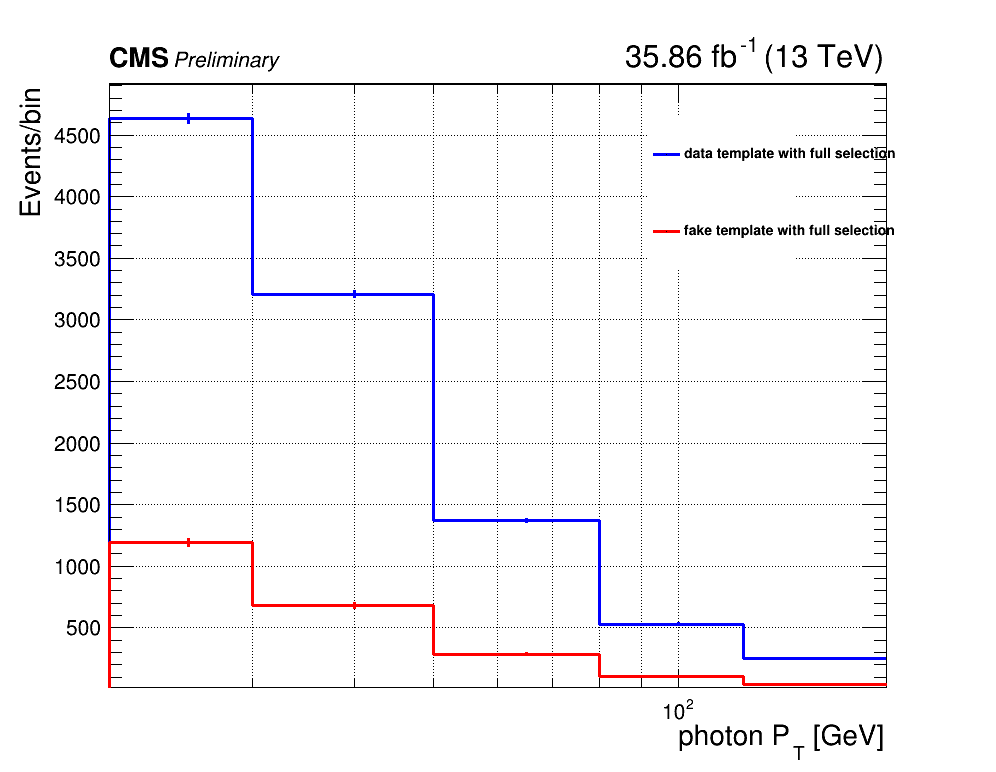

In [6]:
c1 = ROOT.TCanvas("","",1000,800)
c1.Draw()

hist_data.GetXaxis().SetTitle("photon P_{T} [GeV]")
hist_data.GetYaxis().SetTitle("Events/bin")
hist_data.SetMarkerStyle(0)
hist_data.SetLineColor(4)
hist_data.SetLineWidth(3)
hist_data.Draw("HIST e")



hist_datafake.SetMarkerStyle(0)
hist_datafake.SetLineColor(2)
hist_datafake.SetLineWidth(3)
hist_datafake.Draw("HIST SAME e")

legend = ROOT.TLegend(0.65, 0.65, 0.80, 0.85)
legend.SetBorderSize(0)
legend.SetFillColor(0)
legend.SetTextSize(0.020)
legend.SetLineWidth(1)
legend.SetLineStyle(0)
legend.AddEntry(hist_data,'data template with full selection')
legend.AddEntry(hist_datafake,'fake template with full selection')
legend.Draw("SAME")




ROOT.gPad.SetLogx()
ROOT.gPad.SetGrid()

CMS_lumi(c1,0,0)

### Calculate FakeWeight

In [7]:
file1 = ROOT.TFile("DataTemplate_EB_data.root","recreate")
file1.cd()
hist_data.Write()
file1.Close()

file2 = ROOT.TFile("FakeTemplate_EB_fake.root","recreate")
file2.cd()
hist_datafake.Write()
file2.Close()

!ls

2016				    images
2017				    log.csv
2018				    Lumi.py
a				    MagicDraw
Combined_plot_2016.ipynb	    Merged_file
Combined_plot_FakeLepton2016.ipynb  Merged_file_211028
Combined_plot.ipynb		    Merged_file_FakePhoton_211128
Combined_plot_SR2016.ipynb	    Mu_Fake_Rate_2D_2016.root
Combined_plot_ZZ2016.ipynb	    npy_dict
DataTemplate_EB_data.root	    pickle_dict
DataTemplate_EE_data.root	    pickle_dict_sample
Electron_channel		    __pycache__
Ele_Fake_Rate_2D_2016.root	    Ratio_Plot.py
fakefraction_real.csv		    results_2016
FakeLepton2016_Ele.ipynb	    Scale_PDF_Unc.ipynb
FakeLepton2016_Mu.ipynb		    TDR_Style.py
FakeLepton2017_Ele.ipynb	    Template_Fit_2016.ipynb
FakeLepton2018_Ele.ipynb	    Template_Fit_AR_2017.ipynb
FakeLepton_SingleEle_check.ipynb    Template_Fit_AR_2018.ipynb
FakePhoton_2017-2018_hist_ref	    Template_Fit.ipynb
FakeTemplate_EB_fake.root	    Test_Fit.ipynb
FakeTemplate_EE_fake.root	    WZG_sample
FakeWeight_2016.ipynb		    Yeop_test.ipynb


In [8]:
fake_fraction_2016 = {"Barrel":[0.293,0.228,0.233,0.175,0.152],
                    "Endcap":[0.434,0.29]}

In [9]:
for i in range(1,hist_data.GetNbinsX()+1):
    
    ydata= hist_data.GetBinContent(i)
    yfake= hist_datafake.GetBinContent(i)
    
    j = i-1

    if isbarrel == 1:
        fake_fraction = fake_fraction_2016['Barrel'][j]
    elif isbarrel ==0:
        fake_fraction = fake_fraction_2016['Endcap'][j]
    
    
    if (ydata == 0) or (yfake == 0):
        ratio = 0
    else:
        ratio = ydata / yfake
    
    fake_weight = ratio * fake_fraction
    print("{0}th  ydata: {1} yfake:  {2} ydata/yfake: {3:.2f} fake fraction: {4} fake weight: {5:.2f}".format(i,ydata,yfake,ratio,fake_fraction,fake_weight))

1th  ydata: 4635.25634765625 yfake:  1192.313232421875 ydata/yfake: 3.89 fake fraction: 0.293 fake weight: 1.14
2th  ydata: 3209.9169921875 yfake:  677.8638916015625 ydata/yfake: 4.74 fake fraction: 0.228 fake weight: 1.08
3th  ydata: 1372.58935546875 yfake:  287.61834716796875 ydata/yfake: 4.77 fake fraction: 0.233 fake weight: 1.11
4th  ydata: 529.63037109375 yfake:  106.73734283447266 ydata/yfake: 4.96 fake fraction: 0.175 fake weight: 0.87
5th  ydata: 249.5681915283203 yfake:  37.1396369934082 ydata/yfake: 6.72 fake fraction: 0.152 fake weight: 1.02


---

---